<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/wasserstein_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demonstration of the effect of unweighted samples versus weighted samples on the wasserstein distance as a statistic to distinguish two distributions.


1. Draw samples from distribution 1
2. Draw n samples from distribution 2, again
3. Compute the wasserstein distance between samples from steps 1,2
4. Draw n samples from distribution 2
5. Compute the wasserstein distance between samples from steps 1,4
6. Repeats steps 1-5 to make two sets
7. Compute a p-value between the two sets of numbers

The experiments below compare a d=3 dimensional multivariate gaussian to another with a slighly larger variance.

Another experiment shows how to weight the samples by evaluating the pdf at these points. There could be some histogramming of points to reduce the number of points. Or one could drop the points with a low weight (truncate the tails).

If you have access to the density of the distributions, you can simply evaluate the pdf on a grid (important: you can use two different grids for distribution 1 and 2, but use the same grid between comparisons as they evolve (e.g. one is being learned)!). This may not scale well to high dimensions. e.g. for d=10, if you take 5 points per dimension, you have 3**10 = 59049 points. However, one could use a dense grid and then drop the points that have very low density.

In [1]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 15.2 MB/s eta 0:00:00


In [58]:
import numpy as np
import ot
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
from scipy import stats
import time

In [59]:
d = 3

mean = torch.arange(d).to(torch.float32)

var_1 = 1
dist_1 = dist.MultivariateNormal(mean, var_1*torch.eye(d))
var_2 = 1.1
dist_2 = dist.MultivariateNormal(mean, var_2*torch.eye(d))

In [94]:
def sample_points_and_compute_wasserstein(dist_1, dist_2, n_samples, n_trials, emd_kwargs):
  ws_1 = np.empty(n_trials)
  ws_2 = np.empty(n_trials)

  for idx_trial in range(n_trials):
    samples_a1 = dist_1.sample((n_samples,))
    samples_b1 = dist_1.sample((n_samples,))

    samples_a2 = dist_2.sample((n_samples,))

    cost_1 = torch.cdist(samples_a1, samples_b1).numpy()
    cost_2 = torch.cdist(samples_a1, samples_a2).numpy()

    ws_1[idx_trial] = ot.emd2(np.ones(n_samples), np.ones(n_samples), cost_1, **emd_kwargs)
    ws_2[idx_trial] = ot.emd2(np.ones(n_samples), np.ones(n_samples), cost_2, **emd_kwargs)
  return ws_1, ws_2



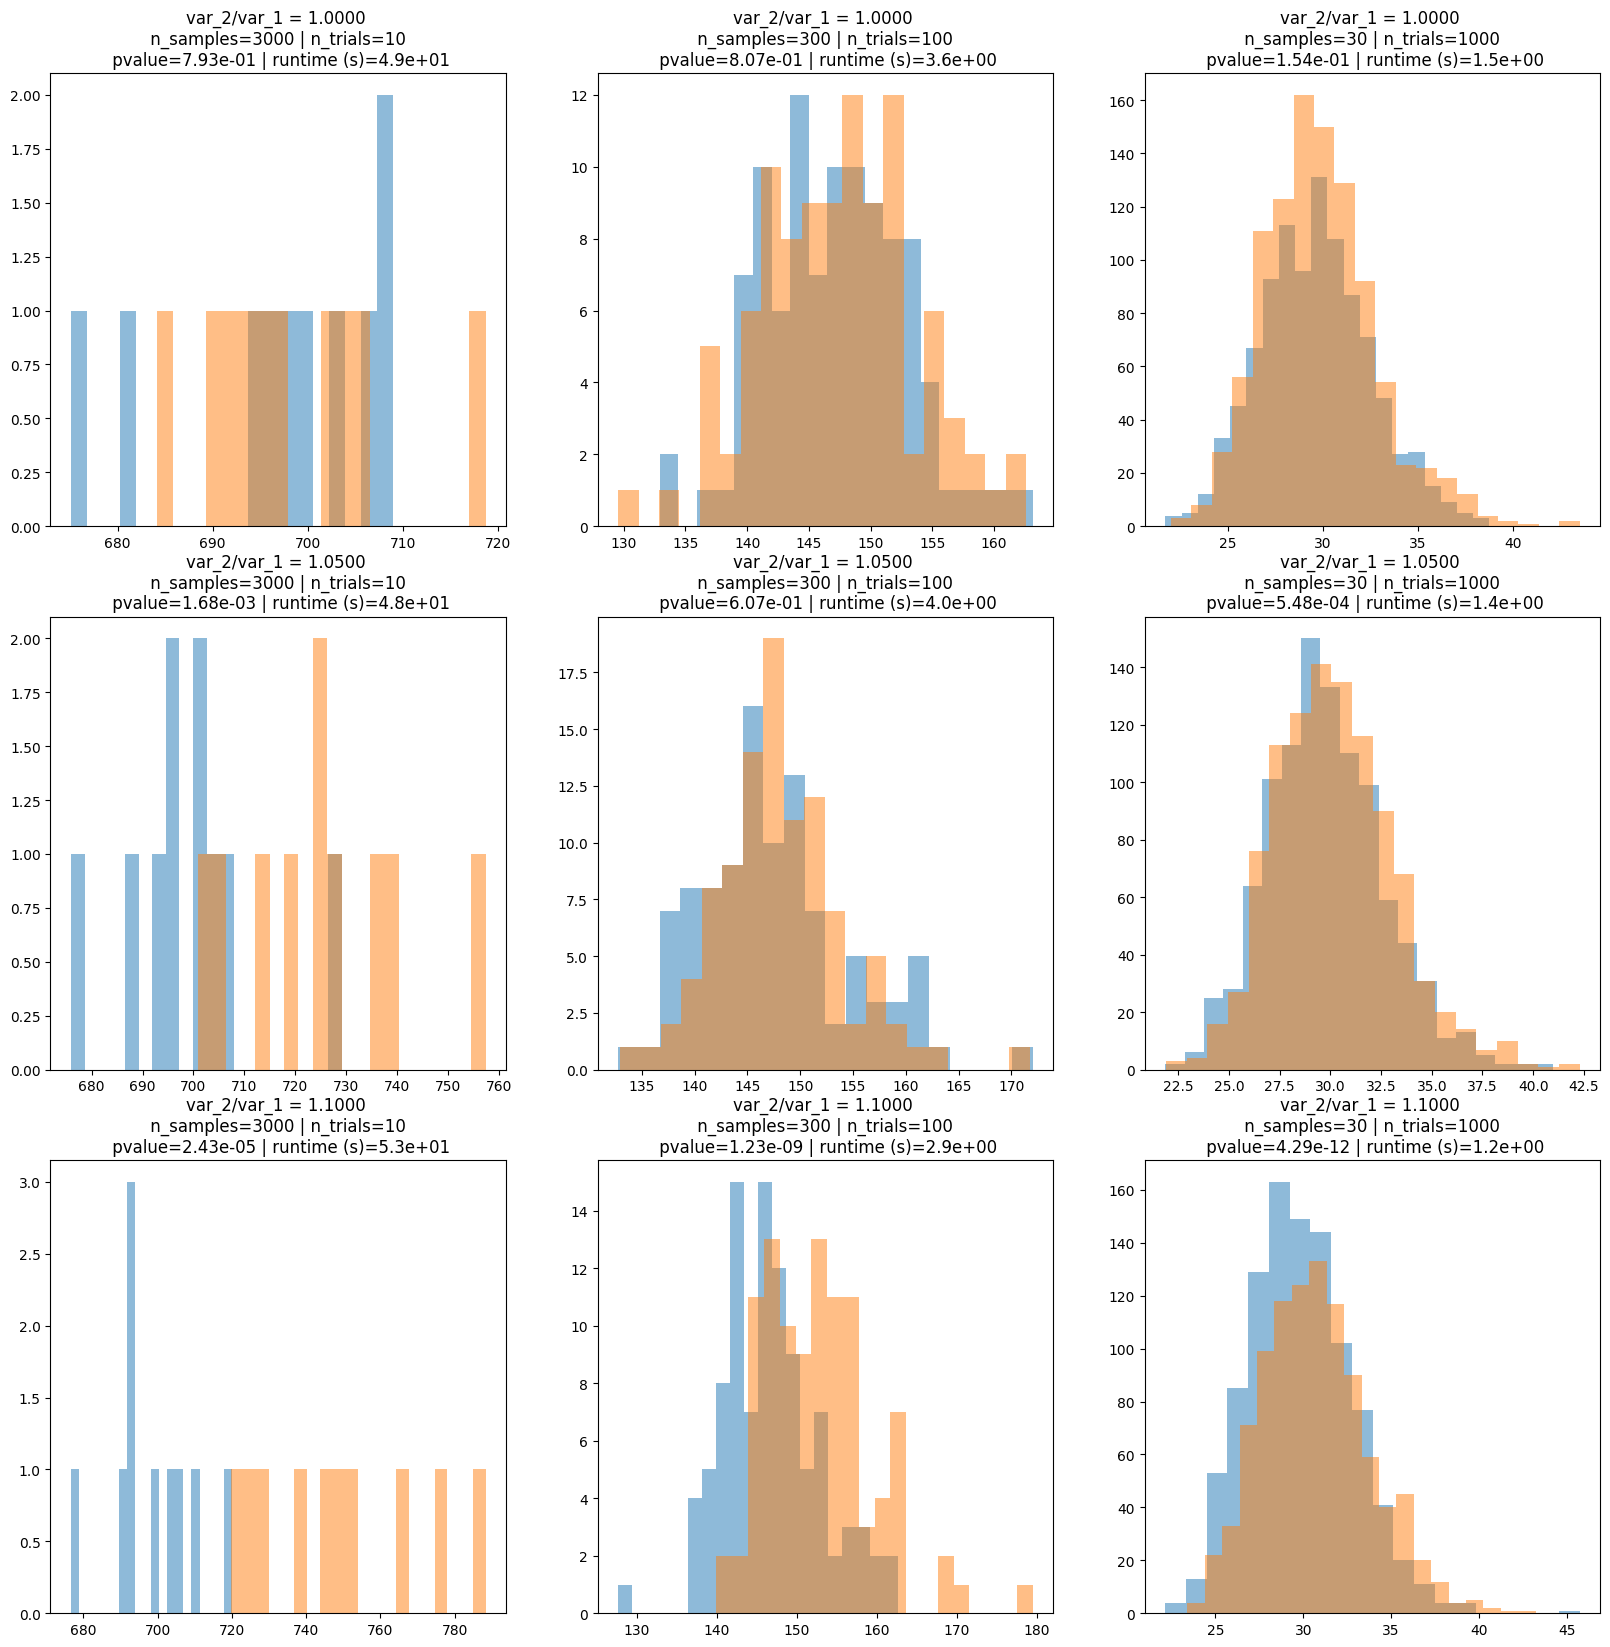

In [98]:
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

for col_idx, (n_trials, n_samples) in enumerate(zip([10,100,1000], [3000,300,30])):

  for row_idx, var_2 in enumerate([1.0,1.05,1.1]):
    dist_2 = dist.MultivariateNormal(mean, var_2*torch.eye(d))
    s = time.time()
    ws_1, ws_2 = sample_points_and_compute_wasserstein(dist_1, dist_2, n_samples, n_trials, emd_kwargs={'numItermax':100000})
    e = time.time()
    runtime = e - s
    _, p_value = stats.ttest_ind(ws_1, ws_2, equal_var=False)  # Welch’s t-test

    axes[row_idx,col_idx].hist(ws_1, bins=20, alpha=0.5)
    axes[row_idx,col_idx].hist(ws_2, bins=20, alpha=0.5)
    axes[row_idx,col_idx].set_title('var_2/var_1 = {:1.3f} \n n_samples={:} | n_trials={:} \n pvalue={:1.2e} | runtime (s)={:1.1e}'.format(var_2/var_1,n_samples,n_trials,p_value, runtime))

In [102]:
def evaluate_pdf_and_compute_wasserstein(dist_1, dist_2, n_samples, n_trials, emd_kwargs):
  ws_1 = np.empty(n_trials)
  ws_2 = np.empty(n_trials)

  for idx_trial in range(n_trials):
    samples_a1 = dist_1.sample((n_samples,))
    samples_b1 = dist_1.sample((n_samples,))

    samples_a2 = dist_2.sample((n_samples,))

    marginal_a1 = dist_1.log_prob(samples_a1).exp().numpy()
    marginal_a1 /= marginal_a1.sum()

    marginal_b1 = dist_1.log_prob(samples_b1).exp().numpy()
    marginal_b1 /= marginal_b1.sum()

    marginal_a2 = dist_2.log_prob(samples_a2).exp().numpy()
    marginal_a2 /= marginal_a2.sum()

    cost_1 = torch.cdist(samples_a1, samples_b1).numpy()
    cost_2 = torch.cdist(samples_a1, samples_a2).numpy()

    ws_1[idx_trial] = ot.emd2(marginal_a1, marginal_b1, cost_1, **emd_kwargs)
    ws_2[idx_trial] = ot.emd2(marginal_a1, marginal_a2, cost_2, **emd_kwargs)
  return ws_1, ws_2

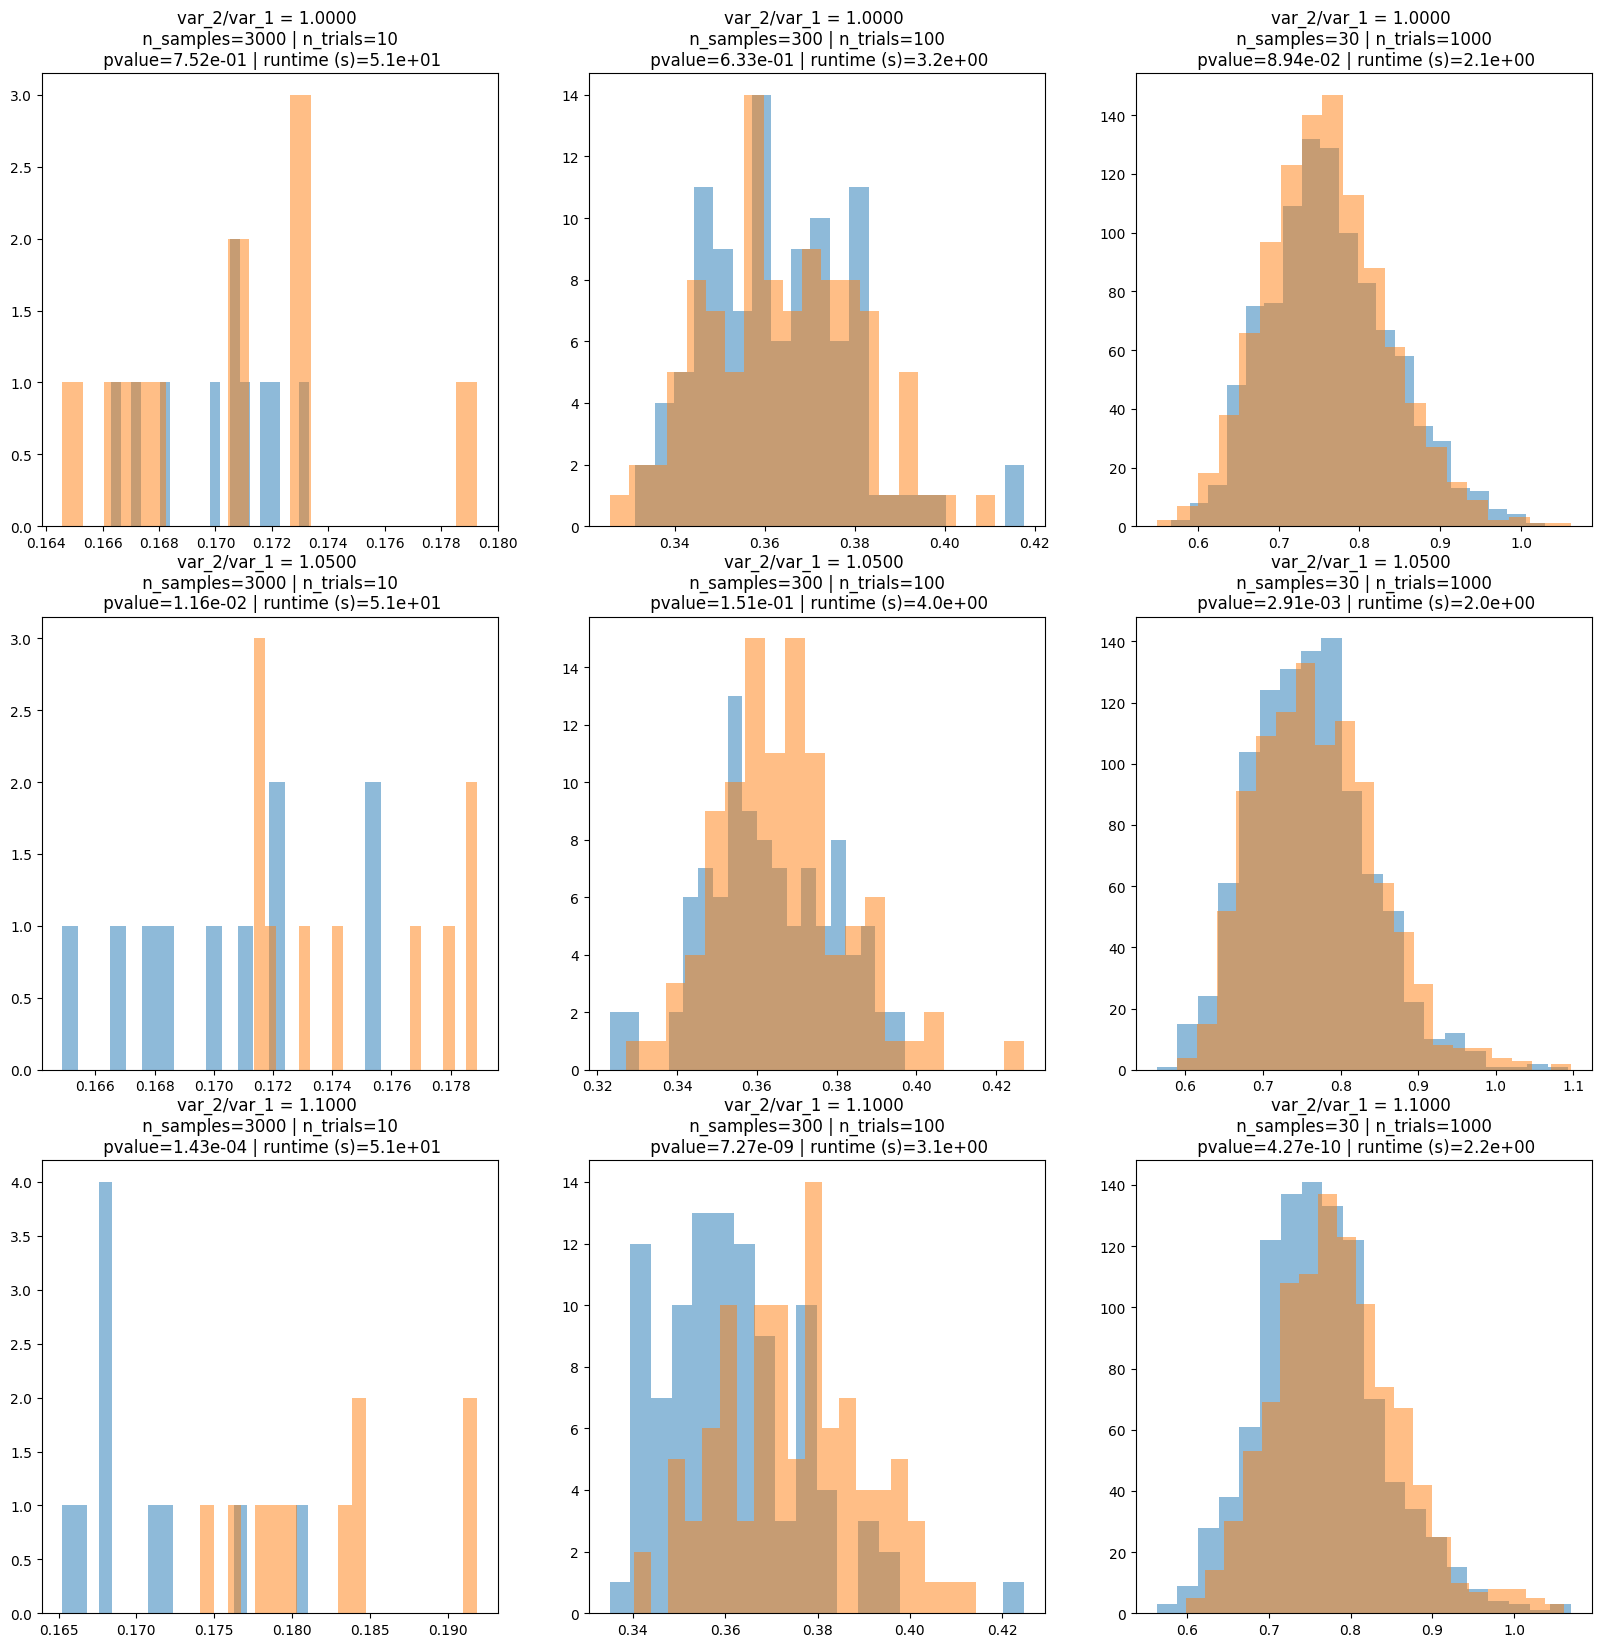

In [103]:
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

for col_idx, (n_trials, n_samples) in enumerate(zip([10,100,1000], [3000,300,30])):

  for row_idx, var_2 in enumerate([1.0,1.05,1.1]):
    dist_2 = dist.MultivariateNormal(mean, var_2*torch.eye(d))
    s = time.time()
    ws_1, ws_2 = evaluate_pdf_and_compute_wasserstein(dist_1, dist_2, n_samples, n_trials, emd_kwargs={'numItermax':100000})
    e = time.time()
    runtime = e - s
    _, p_value = stats.ttest_ind(ws_1, ws_2, equal_var=False)  # Welch’s t-test

    axes[row_idx,col_idx].hist(ws_1, bins=20, alpha=0.5)
    axes[row_idx,col_idx].hist(ws_2, bins=20, alpha=0.5)
    axes[row_idx,col_idx].set_title('var_2/var_1 = {:1.4f} \n n_samples={:} | n_trials={:} \n pvalue={:1.2e} | runtime (s)={:1.1e}'.format(var_2/var_1,n_samples,n_trials,p_value, runtime))

In [104]:
var_2s = torch.linspace(1,2,10)

ws = np.empty(len(var_2s))
for idx, var_2 in enumerate(var_2s):
  dist_2 = dist.MultivariateNormal(mean, var_2*torch.eye(d))

  n_points_1d = 3

  grid_1d = torch.linspace(-3*var_2s.max(), 3*var_2s.max(), n_points_1d)
  xg, yg, zg = torch.meshgrid(grid_1d,grid_1d,grid_1d, indexing='ij')
  grid_xyz = torch.stack([xg,yg,zg], dim=-1).reshape(-1,d)

  marginal_1 = dist_1.log_prob(grid_xyz).exp().numpy()
  marginal_1 /= marginal_1.sum()

  marginal_2 = dist_2.log_prob(grid_xyz).exp().numpy()
  marginal_2 /= marginal_2.sum()

  cost = torch.cdist(grid_xyz, grid_xyz).numpy()

  ws[idx] = ot.emd2(marginal_1, marginal_2, cost)



Text(0, 0.5, 'Wasserstein distance')

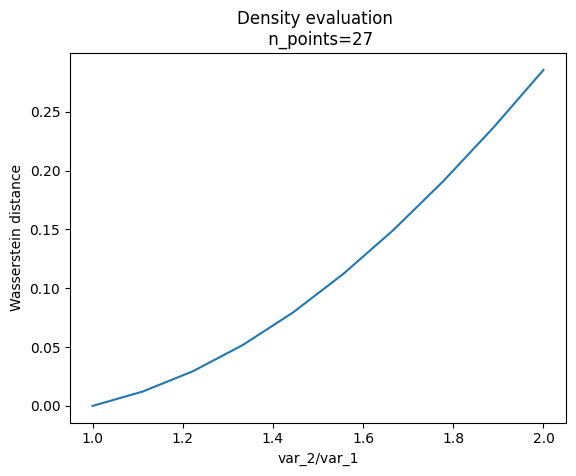

In [105]:
plt.plot(var_2s, ws)
plt.title(f'Density evaluation \n n_points={n_points_1d**3}')
plt.xlabel('var_2/var_1')
plt.ylabel('Wasserstein distance')